## Load and clean provided MPC dataset

In [2]:
import pandas as pd
import pandas as pd
from IPython.display import display
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from scipy import stats
from sklearn.preprocessing import PowerTransformer

In [3]:
def load_data(**paths):
    """
    Load multiple datasets based on provided file paths.

    Parameters:
    **paths: Arbitrary number of keyword arguments where the key is a label 
             and the value is the file path.

    Returns:
    dict: A dictionary where keys are the labels and values are the corresponding pandas DataFrames.
    """
    dataframes = {}

    for name, path in paths.items():
        if path.endswith('.csv'):
            df = pd.read_csv(path)
        elif path.endswith(('.xls', '.xlsx')):
            df = pd.read_excel(path)
        else:
            raise ValueError(f"Unsupported file format for '{name}': {path}")
        
        display(df.head())
        dataframes[name] = df

    return dataframes

In [4]:
# Import MPC data and prepare for further segmenting speeches
mpc_path = r"/Users/rebo/Documents/LSE/Course 4 - EP/Initial datasets/mpcvoting.xlsx"

data = load_data( mpc=mpc_path)

mpc_df_og = data['mpc']

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54
0,NaN,NaN,NaN,Monetary Policy Committee voting history - Ban...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,Current members,Andrew Bailey,Sarah Breeden,Swati Dhingra,Megan Greene,Clare Lombardelli,Catherine L Mann,Huw Pill,...,Michael\nSaunders,Andrew Sentance,Nemat Shafik,Silvana Tenreyro,Paul Tucker,John Vickers,Gertjan\nVlieghe,Sushil Wadhwani,David Walton,Martin Weale
3,NaN,NaN,NaN,First vote:\n19 Mar 20,First vote:\n2 Nov 23,First vote:\n22 Sep 22,First vote:\n3 Aug 23,First vote:\n1 Aug 24,First vote:\n23 Sep 21,First vote:\n23 Sep 21,...,Last vote:\n4 Aug 22,Last vote:\n5 May 11,Last vote:\n2 Feb 17,Last vote:\n22 June 23,Last vote:\n9 Oct 13,Last vote:\n7 Sep 00,Last vote:\n5 Aug 21,Last vote:\n9 May 02,Last vote:\n8 Jun 06,Last vote:\n4 Aug 16
4,NaN,Voted to increase,NaN,14,0,2,4,0,18,14,...,15,20,0,9,13,10,2,3,2,12


In [5]:
# Build memebers and status dataset
# Get the row with names
row = mpc_df_og.iloc[2]

# Convert to Series to ensure we treat it like a 1D array
row_series = pd.Series(row)

# Find positions (not labels) of the marker columns
current_pos = row_series[row_series == "Current members"].index[0]
past_pos = row_series[row_series == "Past members"].index[0]

# Convert to actual positions
current_idx = row_series.index.get_loc(current_pos)
past_idx = row_series.index.get_loc(past_pos)

# Get names by position
current_members = row_series.iloc[current_idx + 1 : past_idx].dropna().tolist()
past_members = row_series.iloc[past_idx + 1 :].dropna().tolist()

# Build the dataset
member_data = pd.DataFrame({
    "name": current_members + past_members,
    "status": ["current"] * len(current_members) + ["past"] * len(past_members)
})

display(member_data)

,name,status
0,Andrew Bailey,current
1,Sarah Breeden,current
2,Swati Dhingra,current
3,Megan Greene,current
4,Clare Lombardelli,current
5,Catherine L Mann,current
6,Huw Pill,current
7,Dave Ramsden,current
8,Alan Taylor,current
9,Christopher Allsopp,past


In [6]:
# Since speech data has only family names of authors, I'll clean the names
def split_name(name):
    # Fix line breaks first -> noticed some names are separated with "\n" instead of space
    name = name.replace("\n", " ").strip().lower()

    # Split into parts
    parts = name.split()

    if len(parts) < 2:
        # If it’s a single name, duplicate it for safety -> if any
        return name, name

    # Assume last part is family name, rest is given name
    given_name = " ".join(parts[:-1])
    family_name = parts[-1]

    return given_name, family_name

# Apply the function to the name column
member_data[['given_name', 'family_name']] = member_data['name'].apply(
    lambda x: pd.Series(split_name(x))
)

display(member_data)

,name,status,given_name,family_name
0,Andrew Bailey,current,andrew,bailey
1,Sarah Breeden,current,sarah,breeden
2,Swati Dhingra,current,swati,dhingra
3,Megan Greene,current,megan,greene
4,Clare Lombardelli,current,clare,lombardelli
5,Catherine L Mann,current,catherine l,mann
6,Huw Pill,current,huw,pill
7,Dave Ramsden,current,dave,ramsden
8,Alan Taylor,current,alan,taylor
9,Christopher Allsopp,past,christopher,allsopp


In [7]:
mpc_df_og.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54
0,NaN,NaN,NaN,Monetary Policy Committee voting history - Ban...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,Current members,Andrew Bailey,Sarah Breeden,Swati Dhingra,Megan Greene,Clare Lombardelli,Catherine L Mann,Huw Pill,...,Michael\nSaunders,Andrew Sentance,Nemat Shafik,Silvana Tenreyro,Paul Tucker,John Vickers,Gertjan\nVlieghe,Sushil Wadhwani,David Walton,Martin Weale
3,NaN,NaN,NaN,First vote:\n19 Mar 20,First vote:\n2 Nov 23,First vote:\n22 Sep 22,First vote:\n3 Aug 23,First vote:\n1 Aug 24,First vote:\n23 Sep 21,First vote:\n23 Sep 21,...,Last vote:\n4 Aug 22,Last vote:\n5 May 11,Last vote:\n2 Feb 17,Last vote:\n22 June 23,Last vote:\n9 Oct 13,Last vote:\n7 Sep 00,Last vote:\n5 Aug 21,Last vote:\n9 May 02,Last vote:\n8 Jun 06,Last vote:\n4 Aug 16
4,NaN,Voted to increase,NaN,14,0,2,4,0,18,14,...,15,20,0,9,13,10,2,3,2,12
5,NaN,Voted to maintain,NaN,24,9,9,8,3,10,13,...,30,28,28,39,114,11,48,18,8,60
6,NaN,Voted to reduce,NaN,4,3,10,2,3,1,2,...,5,8,1,2,10,7,4,16,2,1
7,NaN,Meetings,NaN,42,12,21,14,6,29,29,...,50,56,29,50,137,28,54,37,12,73
8,NaN,NaN,Bank Rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Take a slightly different route - handle the data altogether and clean
# Drop the first column and the first 2 rows
mpc_df_og_cleaned = mpc_df_og.drop(columns=mpc_df_og.columns[0]).drop(index=range(2)).reset_index(drop=True)

mpc_df_og_cleaned.head(10)

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54
0,NaN,Current members,Andrew Bailey,Sarah Breeden,Swati Dhingra,Megan Greene,Clare Lombardelli,Catherine L Mann,Huw Pill,Dave Ramsden,...,Michael\nSaunders,Andrew Sentance,Nemat Shafik,Silvana Tenreyro,Paul Tucker,John Vickers,Gertjan\nVlieghe,Sushil Wadhwani,David Walton,Martin Weale
1,NaN,NaN,First vote:\n19 Mar 20,First vote:\n2 Nov 23,First vote:\n22 Sep 22,First vote:\n3 Aug 23,First vote:\n1 Aug 24,First vote:\n23 Sep 21,First vote:\n23 Sep 21,First vote:\n14 Sep 17,...,Last vote:\n4 Aug 22,Last vote:\n5 May 11,Last vote:\n2 Feb 17,Last vote:\n22 June 23,Last vote:\n9 Oct 13,Last vote:\n7 Sep 00,Last vote:\n5 Aug 21,Last vote:\n9 May 02,Last vote:\n8 Jun 06,Last vote:\n4 Aug 16
2,Voted to increase,NaN,14,0,2,4,0,18,14,16,...,15,20,0,9,13,10,2,3,2,12
3,Voted to maintain,NaN,24,9,9,8,3,10,13,39,...,30,28,28,39,114,11,48,18,8,60
4,Voted to reduce,NaN,4,3,10,2,3,1,2,8,...,5,8,1,2,10,7,4,16,2,1
5,Meetings,NaN,42,12,21,14,6,29,29,63,...,50,56,29,50,137,28,54,37,12,73
6,NaN,Bank Rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1997-06-06 00:00:00,0.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1997-07-10 00:00:00,0.0675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Split the information in row [1] to date and its label
row_1 = mpc_df_og_cleaned.iloc[1]

# Split each cell on '\n' into two pieces
split_rows = row_1.apply(lambda x: x.split('\n') if isinstance(x, str) and '\n' in x else [x, None])

# Create two new rows: labels and dates
labels_row = split_rows.apply(lambda x: x[0])
dates_row = split_rows.apply(lambda x: x[1])

# Replace original row 1 with the label row
mpc_df_og_cleaned.iloc[1] = labels_row

# Insert the date row as a new row after row 1 (i.e., at index 2)
mpc_df_og_cleaned = pd.concat([
    mpc_df_og_cleaned.iloc[:2],          # rows before insert point
    pd.DataFrame([dates_row]),           # new date row
    mpc_df_og_cleaned.iloc[2:].reset_index(drop=True)  # remaining rows
]).reset_index(drop=True)

display(mpc_df_og_cleaned.head(15))

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54
0,NaN,Current members,Andrew Bailey,Sarah Breeden,Swati Dhingra,Megan Greene,Clare Lombardelli,Catherine L Mann,Huw Pill,Dave Ramsden,...,Michael\nSaunders,Andrew Sentance,Nemat Shafik,Silvana Tenreyro,Paul Tucker,John Vickers,Gertjan\nVlieghe,Sushil Wadhwani,David Walton,Martin Weale
1,NaN,NaN,First vote:,First vote:,First vote:,First vote:,First vote:,First vote:,First vote:,First vote:,...,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:
2,None,None,19 Mar 20,2 Nov 23,22 Sep 22,3 Aug 23,1 Aug 24,23 Sep 21,23 Sep 21,14 Sep 17,...,4 Aug 22,5 May 11,2 Feb 17,22 June 23,9 Oct 13,7 Sep 00,5 Aug 21,9 May 02,8 Jun 06,4 Aug 16
3,Voted to increase,NaN,14,0,2,4,0,18,14,16,...,15,20,0,9,13,10,2,3,2,12
4,Voted to maintain,NaN,24,9,9,8,3,10,13,39,...,30,28,28,39,114,11,48,18,8,60
5,Voted to reduce,NaN,4,3,10,2,3,1,2,8,...,5,8,1,2,10,7,4,16,2,1
6,Meetings,NaN,42,12,21,14,6,29,29,63,...,50,56,29,50,137,28,54,37,12,73
7,NaN,Bank Rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1997-06-06 00:00:00,0.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Create sub-set for vote stats and transpose it
mpc_member_votes = mpc_df_og_cleaned.iloc[:7].copy().T.reset_index(drop=True)

# Force all column names to be unique temporarily and drop unnecessary
mpc_member_votes.columns = [f"col_{i}" for i in range(len(mpc_member_votes.columns))]

mpc_member_votes.drop(columns=["col_1"], inplace=True)

# Rename the remaining columns properly
mpc_member_votes.rename(columns={
    "col_0": "name",
    "col_2": "first / last vote",
    "col_3": "voted to increase",
    "col_4": "voted to maintain",
    "col_5": "voted to reduce",
    "col_6": "meeting"
}, inplace=True)

# Create a new column for member status
# Get index positions of the section headers
current_idx = mpc_member_votes[mpc_member_votes['name'] == "Current members"].index[0]
past_idx = mpc_member_votes[mpc_member_votes['name'] == "Past members"].index[0]

# Create a new 'status' column with default empty string
mpc_member_votes['status'] = ''

# Assign statuses
mpc_member_votes.loc[current_idx + 1:past_idx - 1, 'status'] = 'current'
mpc_member_votes.loc[past_idx + 1:, 'status'] = 'past'

mpc_member_votes.head(20)

# clean up records 
mpc_member_vote_clean = mpc_member_votes.drop(index=[0, 1])
mpc_member_vote_clean = mpc_member_vote_clean[mpc_member_vote_clean['name'] != "Past members"].reset_index(drop=True)

mpc_member_vote_clean.head(15)

,name,first / last vote,voted to increase,voted to maintain,voted to reduce,meeting,status
0,Andrew Bailey,19 Mar 20,14,24,4,42,current
1,Sarah Breeden,2 Nov 23,0,9,3,12,current
2,Swati Dhingra,22 Sep 22,2,9,10,21,current
3,Megan Greene,3 Aug 23,4,8,2,14,current
4,Clare Lombardelli,1 Aug 24,0,3,3,6,current
5,Catherine L Mann,23 Sep 21,18,10,1,29,current
6,Huw Pill,23 Sep 21,14,13,2,29,current
7,Dave Ramsden,14 Sep 17,16,39,8,63,current
8,Alan Taylor,19 Sep 24,0,2,3,5,current
9,Christopher Allsopp,8 May 03,0,19,18,37,past


In [11]:
# Split names
def split_name(name):
    name = name.replace("\n", " ").strip().lower()   # Normalize and clean
    parts = name.split()                             # Split into parts

    if len(parts) < 2:
        return name, name  # fallback for single-word names

    given_name = " ".join(parts[:-1])
    family_name = parts[-1]

    return given_name, family_name

# Apply the function and add columns
mpc_member_vote_clean[['given_name', 'family_name']] = mpc_member_vote_clean['name'].apply(
    lambda x: pd.Series(split_name(x))
)

# Create year and month columns
# Convert 'first / last vote' to datetime  with mixed formats and handle bad values
mpc_member_vote_clean['first / last vote'] = pd.to_datetime(
    mpc_member_vote_clean['first / last vote'], 
    errors='coerce',          # Handle errors
    dayfirst=True,            # most looks like day month year
    format='mixed'            # check by row
)

# Now extract year and month - for current members first voted - for part members last voted
mpc_member_vote_clean['vote_year'] = mpc_member_vote_clean['first / last vote'].dt.year
mpc_member_vote_clean['vote_month'] = mpc_member_vote_clean['first / last vote'].dt.month

# Select and reorder the final columns
final_columns = [
    'family_name', 
    'status', 
    'vote_year', 
    'vote_month', 
    'voted to increase', 
    'voted to maintain', 
    'voted to reduce', 
    'meeting'
]

mpc_member_vote_clean = mpc_member_vote_clean[final_columns]

mpc_member_vote_clean.head(15)

# Save to Excel
mpc_member_vote_clean.to_excel('mpc_member_votes.xlsx', index=False)

In [12]:
mpc_member_vote_clean.head(15)

,family_name,status,vote_year,vote_month,voted to increase,voted to maintain,voted to reduce,meeting
0,bailey,current,2020,3,14,24,4,42
1,breeden,current,2023,11,0,9,3,12
2,dhingra,current,2022,9,2,9,10,21
3,greene,current,2023,8,4,8,2,14
4,lombardelli,current,2024,8,0,3,3,6
5,mann,current,2021,9,18,10,1,29
6,pill,current,2021,9,14,13,2,29
7,ramsden,current,2017,9,16,39,8,63
8,taylor,current,2024,9,0,2,3,5
9,allsopp,past,2003,5,0,19,18,37


In [13]:
mpc_df_og_cleaned.head(15)

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54
0,NaN,Current members,Andrew Bailey,Sarah Breeden,Swati Dhingra,Megan Greene,Clare Lombardelli,Catherine L Mann,Huw Pill,Dave Ramsden,...,Michael\nSaunders,Andrew Sentance,Nemat Shafik,Silvana Tenreyro,Paul Tucker,John Vickers,Gertjan\nVlieghe,Sushil Wadhwani,David Walton,Martin Weale
1,NaN,NaN,First vote:,First vote:,First vote:,First vote:,First vote:,First vote:,First vote:,First vote:,...,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:
2,None,None,19 Mar 20,2 Nov 23,22 Sep 22,3 Aug 23,1 Aug 24,23 Sep 21,23 Sep 21,14 Sep 17,...,4 Aug 22,5 May 11,2 Feb 17,22 June 23,9 Oct 13,7 Sep 00,5 Aug 21,9 May 02,8 Jun 06,4 Aug 16
3,Voted to increase,NaN,14,0,2,4,0,18,14,16,...,15,20,0,9,13,10,2,3,2,12
4,Voted to maintain,NaN,24,9,9,8,3,10,13,39,...,30,28,28,39,114,11,48,18,8,60
5,Voted to reduce,NaN,4,3,10,2,3,1,2,8,...,5,8,1,2,10,7,4,16,2,1
6,Meetings,NaN,42,12,21,14,6,29,29,63,...,50,56,29,50,137,28,54,37,12,73
7,NaN,Bank Rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1997-06-06 00:00:00,0.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 

In [15]:
# Create subset of bank rates voted
mpc_df_og_cleaned.columns = [f"col_{i}" for i in range(len(mpc_df_og_cleaned.columns))]

# Create header and drop unnecessary rows
mpc_bank_rates_voted = mpc_df_og_cleaned.iloc[:,:2].drop(index=range(9)).reset_index(drop=True)

# Name columns
mpc_bank_rates_voted.rename(columns={
    "col_0": "date",
    "col_1": "bank_rate"
}, inplace=True)

# Convert vote date to datetime  with mixed formats and handle bad values
mpc_bank_rates_voted['date'] = pd.to_datetime(
    mpc_bank_rates_voted['date'], 
    errors='coerce',          # Handle errors
    dayfirst=True,            # most looks like day month year
    format='mixed'            # check by row
)

# Now extract year and month
mpc_bank_rates_voted['vote_year'] = mpc_bank_rates_voted['date'].dt.year
mpc_bank_rates_voted['vote_month'] = mpc_bank_rates_voted['date'].dt.month

# Calculate the difference in bank rate from the previous row
mpc_bank_rates_voted['rate_diff'] = mpc_bank_rates_voted['bank_rate'].diff()

# Categorize the difference
mpc_bank_rates_voted['rate_change'] = mpc_bank_rates_voted['rate_diff'].apply(
    lambda x: 'increase' if x > 0 else ('reduce' if x < 0 else 'maintain')
)

display(mpc_bank_rates_voted.head(5))

max_diff = mpc_bank_rates_voted['rate_diff'].max()
min_diff = mpc_bank_rates_voted['rate_diff'].min()

print(f"Max rate change: {max_diff}")
print(f"Min rate change: {min_diff}")


,date,bank_rate,vote_year,vote_month,rate_diff,rate_change
0,1997-06-06,0.065,1997,6,NaN,maintain
1,1997-07-10,0.0675,1997,7,0.0025,increase
2,1997-08-07,0.07,1997,8,0.0025,increase
3,1997-09-11,0.07,1997,9,0.0,maintain
4,1997-10-09,0.07,1997,10,0.0,maintain


Max rate change: 0.0075
Min rate change: -0.015


In [16]:
# Check if there were multiple votes per month
# Group by year and month, count how many rate votes occurred
rate_vote_summary = mpc_bank_rates_voted.groupby(['vote_year', 'vote_month']).size().reset_index(name='vote_count')

# Select  multi vote months
multiple_votes = rate_vote_summary[rate_vote_summary['vote_count'] > 1]

print(multiple_votes)

     vote_year  vote_month  vote_count
51        2001           9           2
259       2020           3           3


### To handle multiple votes in a month for now I take the last vote of the months where multiple vote occured and calculate the change there.
=> to be revised for weekly (or 7 days window) splits from vote days for more accuracy

In [18]:
# Keep only last vote of the month
mpc_bank_rates_voted_cleaned = mpc_bank_rates_voted.sort_values('date').drop_duplicates(
    subset=['vote_year', 'vote_month'],
    keep='last'
).reset_index(drop=True)

mpc_bank_rates_voted_cleaned.head(5)

,date,bank_rate,vote_year,vote_month,rate_diff,rate_change
0,1997-06-06,0.065,1997,6,NaN,maintain
1,1997-07-10,0.0675,1997,7,0.0025,increase
2,1997-08-07,0.07,1997,8,0.0025,increase
3,1997-09-11,0.07,1997,9,0.0,maintain
4,1997-10-09,0.07,1997,10,0.0,maintain


In [19]:
# Check for remaining duplicates — should return empty
dupes = mpc_bank_rates_voted_cleaned.duplicated(subset=['vote_year', 'vote_month'], keep=False)
mpc_bank_rates_voted_cleaned[dupes]

,date,bank_rate,vote_year,vote_month,rate_diff,rate_change


In [20]:
# Recalculate rate_diff and recaliber rate_change flag
mpc_bank_rates_voted_cleaned = mpc_bank_rates_voted_cleaned.sort_values('date').reset_index(drop=True)

# Calculate rate_diff = current rate minus previous rate
mpc_bank_rates_voted_cleaned['rate_diff'] = mpc_bank_rates_voted_cleaned['bank_rate'].diff()

# Optional: classify the type of change
mpc_bank_rates_voted_cleaned['rate_change'] = mpc_bank_rates_voted_cleaned['rate_diff'].apply(
    lambda x: 'increase' if x > 0 else ('reduce' if x < 0 else 'maintain')
)
mpc_bank_rates_voted_cleaned.head(15)

,date,bank_rate,vote_year,vote_month,rate_diff,rate_change
0,1997-06-06,0.065,1997,6,NaN,maintain
1,1997-07-10,0.0675,1997,7,0.0025,increase
2,1997-08-07,0.07,1997,8,0.0025,increase
3,1997-09-11,0.07,1997,9,0.0,maintain
4,1997-10-09,0.07,1997,10,0.0,maintain
5,1997-11-06,0.0725,1997,11,0.0025,increase
6,1997-12-04,0.0725,1997,12,0.0,maintain
7,1998-01-08,0.0725,1998,1,0.0,maintain
8,1998-02-05,0.0725,1998,2,0.0,maintain
9,1998-03-05,0.0725,1998,3,0.0,maintain


In [21]:
mpc_bank_rates_voted_cleaned.to_excel('mpc_bank_rates_voted_monthly.xlsx', index=False)

In [22]:
# Save to Excel - for now on hold, apply new version (above)
# mpc_bank_rates_voted.to_excel('mpc_bank_rates_voted.xlsx', index=False)

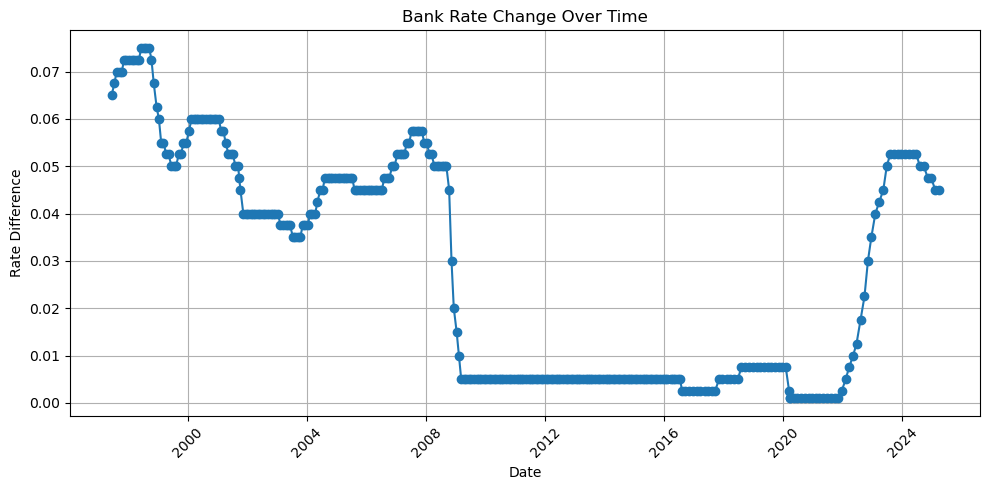

In [23]:
# Quick visual for voted rates
plt.figure(figsize=(10, 5))
plt.plot(mpc_bank_rates_voted['date'], mpc_bank_rates_voted['bank_rate'], marker='o', linestyle='-')
plt.title('Bank Rate Change Over Time')
plt.xlabel('Date')
plt.ylabel('Rate Difference')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

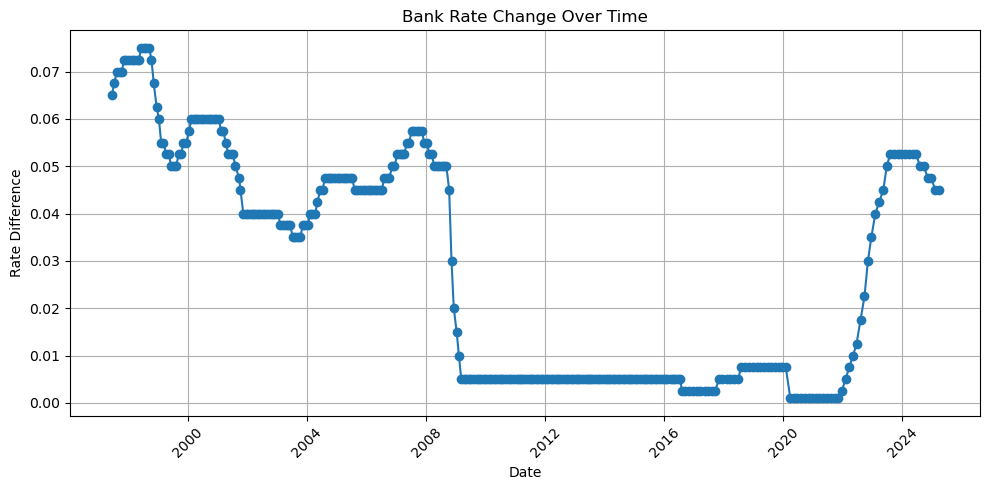

In [24]:
# Quick visual for voted rates in the monthly cleaned data
plt.figure(figsize=(10, 5))
plt.plot(mpc_bank_rates_voted_cleaned['date'], mpc_bank_rates_voted_cleaned['bank_rate'], marker='o', linestyle='-')
plt.title('Bank Rate Change Over Time')
plt.xlabel('Date')
plt.ylabel('Rate Difference')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Check MPC members votes -> trying to determine wheather they are part of the popular vote or not -> more or less conservative

In [26]:
mpc_df_og_cleaned.head(15)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53
0,NaN,Current members,Andrew Bailey,Sarah Breeden,Swati Dhingra,Megan Greene,Clare Lombardelli,Catherine L Mann,Huw Pill,Dave Ramsden,...,Michael\nSaunders,Andrew Sentance,Nemat Shafik,Silvana Tenreyro,Paul Tucker,John Vickers,Gertjan\nVlieghe,Sushil Wadhwani,David Walton,Martin Weale
1,NaN,NaN,First vote:,First vote:,First vote:,First vote:,First vote:,First vote:,First vote:,First vote:,...,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:,Last vote:
2,None,None,19 Mar 20,2 Nov 23,22 Sep 22,3 Aug 23,1 Aug 24,23 Sep 21,23 Sep 21,14 Sep 17,...,4 Aug 22,5 May 11,2 Feb 17,22 June 23,9 Oct 13,7 Sep 00,5 Aug 21,9 May 02,8 Jun 06,4 Aug 16
3,Voted to increase,NaN,14,0,2,4,0,18,14,16,...,15,20,0,9,13,10,2,3,2,12
4,Voted to maintain,NaN,24,9,9,8,3,10,13,39,...,30,28,28,39,114,11,48,18,8,60
5,Voted to reduce,NaN,4,3,10,2,3,1,2,8,...,5,8,1,2,10,7,4,16,2,1
6,Meetings,NaN,42,12,21,14,6,29,29,63,...,50,56,29,50,137,28,54,37,12,73
7,NaN,Bank Rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1997-06-06 00:00:00,0.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
mpc_member_votes = mpc_df_og_cleaned.drop(index=range(1, 9)).reset_index(drop=True)

# Get the name row (index 0) and fix the \n issue
name_row = mpc_member_votes.iloc[0, 2:].replace({r'\n': ' '}, regex=True)

# Split into given and family names
given_names = name_row.apply(lambda x: ' '.join(str(x).split()[:-1]).lower() if pd.notnull(x) else '')
family_names = name_row.apply(lambda x: str(x).split()[-1].lower() if pd.notnull(x) and len(str(x).split()) > 0 else '')

# Create the new rows
new_rows = pd.DataFrame([[""] * 2 + given_names.tolist(), [""] * 2 + family_names.tolist()],
                        columns=mpc_member_votes.columns)

# Insert the new rows after the name row
mpc_member_votes = pd.concat([
    mpc_member_votes.iloc[:1],
    new_rows,
    mpc_member_votes.iloc[1:]
]).reset_index(drop=True)

display(mpc_member_votes.head(15))

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53
0,NaN,Current members,Andrew Bailey,Sarah Breeden,Swati Dhingra,Megan Greene,Clare Lombardelli,Catherine L Mann,Huw Pill,Dave Ramsden,...,Michael\nSaunders,Andrew Sentance,Nemat Shafik,Silvana Tenreyro,Paul Tucker,John Vickers,Gertjan\nVlieghe,Sushil Wadhwani,David Walton,Martin Weale
1,,,andrew,sarah,swati,megan,clare,catherine l,huw,dave,...,michael,andrew,nemat,silvana,paul,john,gertjan,sushil,david,martin
2,,,bailey,breeden,dhingra,greene,lombardelli,mann,pill,ramsden,...,saunders,sentance,shafik,tenreyro,tucker,vickers,vlieghe,wadhwani,walton,weale
3,1997-06-06 00:00:00,0.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1997-07-10 00:00:00,0.0675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1997-08-07 00:00:00,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1997-09-11 00:00:00,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1997-10-09 00:00:00,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1997-11-06 00:00:00,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1997-12-04 00:00:00,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Cleanup, drop the first two rows
mpc_member_votes = mpc_member_votes.iloc[2:].reset_index(drop=True)

# Set the third row (which is now at index 0) as the header
new_header = mpc_member_votes.iloc[0]  # First row after dropping rows 0 and 1
mpc_member_votes.columns = new_header

# Drop the row now used as the header (index 0)
mpc_member_votes = mpc_member_votes.drop(0).reset_index(drop=True)

# Check the cleaned DataFrame
mpc_member_votes.head(15)

,,,bailey,breeden,dhingra,greene,lombardelli,mann,pill,ramsden,...,saunders,sentance,shafik,tenreyro,tucker,vickers,vlieghe,wadhwani,walton,weale
0,1997-06-06 00:00:00,0.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1997-07-10 00:00:00,0.0675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1997-08-07 00:00:00,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1997-09-11 00:00:00,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1997-10-09 00:00:00,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1997-11-06 00:00:00,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1997-12-04 00:00:00,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1998-01-08 00:00:00,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1998-02-05 00:00:00,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1998-03-05 00:00:00,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Manually assign the first two columns as 'vote_date' and 'bank_rate'
mpc_member_votes.columns = ['vote_date', 'bank_rate'] + list(mpc_member_votes.columns[2:])

mpc_member_votes.head(15)

,vote_date,bank_rate,bailey,breeden,dhingra,greene,lombardelli,mann,pill,ramsden,...,saunders,sentance,shafik,tenreyro,tucker,vickers,vlieghe,wadhwani,walton,weale
0,1997-06-06 00:00:00,0.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1997-07-10 00:00:00,0.0675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1997-08-07 00:00:00,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1997-09-11 00:00:00,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1997-10-09 00:00:00,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1997-11-06 00:00:00,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1997-12-04 00:00:00,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1998-01-08 00:00:00,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1998-02-05 00:00:00,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1998-03-05 00:00:00,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Convert 'vote_date' to datetime format (ensuring it's in the correct format)
mpc_member_votes['vote_date'] = pd.to_datetime(mpc_member_votes['vote_date'], errors='coerce')

# Check if any conversion failed
if mpc_member_votes['vote_date'].isnull().any():
    print("There were errors in converting 'vote_date' to datetime.")

# Create 'vote_year' and 'vote_month' columns
mpc_member_votes['vote_year'] = mpc_member_votes['vote_date'].dt.year
mpc_member_votes['vote_month'] = mpc_member_votes['vote_date'].dt.month


mpc_member_votes.head()

,vote_date,bank_rate,bailey,breeden,dhingra,greene,lombardelli,mann,pill,ramsden,...,shafik,tenreyro,tucker,vickers,vlieghe,wadhwani,walton,weale,vote_year,vote_month
0,1997-06-06,0.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997,6
1,1997-07-10,0.0675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997,7
2,1997-08-07,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997,8
3,1997-09-11,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997,9
4,1997-10-09,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997,10


In [31]:
# New column with the previous month's bank_rate
mpc_member_votes['previous_bank_rate'] = mpc_member_votes['bank_rate'].shift(1)

# Columns to process
exclude_columns = ['vote_date', 'bank_rate', 'previous_bank_rate', 'vote_year', 'vote_month']
columns_to_process = [col for col in mpc_member_votes.columns if col not in exclude_columns and not col.endswith('_vote')]

# Compare voted rate against the previous bank rate
def calculate_difference(row, column):
    previous_rate = row['previous_bank_rate']
    value = row[column]
    
    if pd.isna(value) or pd.isna(previous_rate):
        return np.nan
    elif value == "Increase":
        return "increase"
    elif value == "Decrease":
        return "reduce"
    else:
        try:
            difference = float(value) - previous_rate  # <-- NOTE: flipped direction!
            
            if difference == 0:
                return "maintain"
            elif difference > 0:
                return "increase"
            else:
                return "reduce"
        except ValueError:
            return value

# Apply the corrected logic
for column in columns_to_process:
    mpc_member_votes[column + '_vote'] = mpc_member_votes.apply(lambda row: calculate_difference(row, column), axis=1)

mpc_member_votes.head(20)

,vote_date,bank_rate,bailey,breeden,dhingra,greene,lombardelli,mann,pill,ramsden,...,saunders_vote,sentance_vote,shafik_vote,tenreyro_vote,tucker_vote,vickers_vote,vlieghe_vote,wadhwani_vote,walton_vote,weale_vote
0,1997-06-06,0.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1997-07-10,0.0675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1997-08-07,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1997-09-11,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1997-10-09,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1997-11-06,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1997-12-04,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1998-01-08,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1998-02-05,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1998-03-05,0.0725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Assuming the new columns have been added to the DataFrame (with '_difference' suffix)
aggregated_votes = {}

# Iterate over each new difference column (e.g., bailey_difference, breeden_difference, ...)
for column in columns_to_process:
    # Count the occurrences of each type of vote for the current member (column)
    vote_counts = mpc_member_votes[column + '_vote'].value_counts()
    
    # Store the result in the dictionary, with the column name as the key
    aggregated_votes[column] = vote_counts

# Convert the dictionary of aggregated votes into a DataFrame for better readability
aggregated_votes_df = pd.DataFrame(aggregated_votes)

# Display the aggregated vote counts
aggregated_votes_df

,bailey,breeden,dhingra,greene,lombardelli,mann,pill,ramsden,taylor,members,...,saunders,sentance,shafik,tenreyro,tucker,vickers,vlieghe,wadhwani,walton,weale
increase,14,NaN,2,4,NaN,18,14,16,NaN,NaN,...,15,20,NaN,9,13,10,2,3,2,12
maintain,24,9.0,9,8,3.0,10,13,39,2.0,NaN,...,30,28,28.0,39,114,11,48,18,8,60
reduce,4,3.0,10,2,3.0,1,2,8,3.0,NaN,...,5,8,1.0,2,10,7,4,16,2,1


In [33]:
# Select only the vote direction columns ('_vote')
vote_columns = [col for col in mpc_member_votes.columns if col.endswith('_vote')]

# Melt just those columns to long format
votes_long = mpc_member_votes.melt(
    id_vars=['vote_date', 'bank_rate'],
    value_vars=vote_columns,
    var_name='author',
    value_name='vote'
)

# Drop rows where vote is missing
votes_long = votes_long.dropna(subset=['vote'])

# Extract year and month from vote_date
votes_long['vote_date'] = pd.to_datetime(votes_long['vote_date'])
votes_long['year'] = votes_long['vote_date'].dt.year
votes_long['month'] = votes_long['vote_date'].dt.month

# Remove the '_vote' suffix from author names
votes_long['author'] = votes_long['author'].str.replace('_vote', '', regex=False)

# Keep only relevant columns
votes_tidy = votes_long[['vote_date', 'author', 'year', 'month', 'vote']].reset_index(drop=True)

votes_tidy.head(15)

,vote_date,author,year,month,vote
0,2020-03-19,bailey,2020,3,reduce
1,2020-03-26,bailey,2020,3,maintain
2,2020-05-07,bailey,2020,5,maintain
3,2020-06-18,bailey,2020,6,maintain
4,2020-08-06,bailey,2020,8,maintain
5,2020-09-17,bailey,2020,9,maintain
6,2020-11-05,bailey,2020,11,maintain
7,2020-12-17,bailey,2020,12,maintain
8,2021-02-04,bailey,2021,2,maintain
9,2021-03-18,bailey,2021,3,maintain


In [34]:
# Bring in status
votes_with_status = votes_tidy.merge(
    mpc_member_vote_clean[['family_name', 'status']],
    how='left',
    left_on='author',
    right_on='family_name'
)

# Drop the redundant family name and reorder columns
votes_with_status.drop(columns='family_name', inplace=True)
votes_with_status = votes_with_status[['vote_date','author', 'status', 'year', 'month', 'vote']]

votes_with_status.head(15)

,vote_date,author,status,year,month,vote
0,2020-03-19,bailey,current,2020,3,reduce
1,2020-03-26,bailey,current,2020,3,maintain
2,2020-05-07,bailey,current,2020,5,maintain
3,2020-06-18,bailey,current,2020,6,maintain
4,2020-08-06,bailey,current,2020,8,maintain
5,2020-09-17,bailey,current,2020,9,maintain
6,2020-11-05,bailey,current,2020,11,maintain
7,2020-12-17,bailey,current,2020,12,maintain
8,2021-02-04,bailey,current,2021,2,maintain
9,2021-03-18,bailey,current,2021,3,maintain


In [35]:
# Save to Excel
votes_with_status.to_excel('MPC_votes_by_author.xlsx', index=False)